In [1]:
import numpy as np;
import pandas as pd;
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer,roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn
mccScorer = make_scorer(matthews_corrcoef)
roc_auc_scoreScorer=make_scorer(roc_auc_score)

from numpy import mean
from numpy import std

from google.colab import drive
drive.mount("/content/gdrive")

# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

Mounted at /content/gdrive


In [2]:
#read training dataset 1
data1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_1_Training.csv')

X_train_actual_1=data1[:-2].T[1:].values

y_train_actual_1 = data1[-2:].T[-130:].T.values

In [3]:
#read training dataset 2
data2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_2_Training.csv')

X_train_actual_2=data2[:-4].T[1:].values

y_train_actual_2 = data2[-4:].T[-340:].T.values

In [4]:
co1={'X':X_train_actual_1,'Y': y_train_actual_1[0]};
co2={'X':X_train_actual_1,'Y': y_train_actual_1[1]};

co3={'X':X_train_actual_2,'Y': y_train_actual_2[0]};
co4={'X':X_train_actual_2,'Y': y_train_actual_2[1]};
co5={'X':X_train_actual_2,'Y': y_train_actual_2[2]};
co6={'X':X_train_actual_2,'Y': y_train_actual_2[3]};

In [5]:
def logisticRegClassifier_with_HPTuning(X,Y):
  # define model
  model = LogisticRegression()
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
  # define search space
  space = dict()
  space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
  space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
  space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
  # define search
  search = GridSearchCV(model, space, scoring=mccScorer,cv=cv)
  # execute search
  result = search.fit(X, Y.astype('int'))
  # summarize result
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# Hyper parameter tuning for logistic regression
def find_best_hyperparameters_for_logistic_regression():
  print("Log-reg-tuning-CO1 started")
  logisticRegClassifier_with_HPTuning(**co1);
  print("Log-reg-tuning-CO2 started")
  logisticRegClassifier_with_HPTuning(**co2);
  print("Log-reg-tuning-CO3 started")
  logisticRegClassifier_with_HPTuning(**co3);
  print("Log-reg-tuning-CO4 started")
  logisticRegClassifier_with_HPTuning(**co4);
  print("Log-reg-tuning-CO5 started")
  logisticRegClassifier_with_HPTuning(**co5);
  print("Log-reg-tuning-CO6 started")
  logisticRegClassifier_with_HPTuning(**co6);

In [6]:
def feature_selector(X,Y,numberOfFeaturesToBeSelected=1):
  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected=totalNumberOfFeatures//2;
  # define feature selection
  fs = SelectKBest(score_func=f_classif, k=numberOfFeaturesToBeSelected)
  # apply feature selection
  return fs.fit(X, Y)

In [7]:
def determine_number_of_top_features(X,Y):
  X=pd.DataFrame(X)
  X=X.astype(float)

  Y=pd.DataFrame(Y)
  Y=Y.astype(int)

  sel = f_classif(X, Y)
  p_values = pd.Series(sel[1])
  p_values.index = X.columns
  p_values.sort_values(ascending=True, inplace=True)
  p_values = p_values[p_values < 0.05]
  X_p = X[p_values.index]
  return X_p.shape[1]

In [8]:
best_co1=determine_number_of_top_features(**co1)
best_co2=determine_number_of_top_features(**co2)
best_co3=determine_number_of_top_features(**co3)
best_co4=determine_number_of_top_features(**co4)
best_co5=determine_number_of_top_features(**co5)
best_co6=determine_number_of_top_features(**co6)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [9]:
def plot_PRC_for_CV(predictor,k_fold,X,y,label):
  f, axes = plt.subplots(1,1,squeeze=False)
  
  y_real = []
  y_proba = []
  
  for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[0,0].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

  y_real = np.concatenate(y_real)
  y_proba = np.concatenate(y_proba)
  precision, recall, _ = precision_recall_curve(y_real, y_proba)
  lab = 'Overall AUC=%.4f' % (auc(recall, precision))
  axes[0,0].step(recall, precision, label=lab, lw=2, color='black')
  axes[0,0].set_xlabel('Recall')
  axes[0,0].set_ylabel('Precision')
  axes[0,0].legend(loc='lower left', fontsize='small')
  axes[0,0].set(title=label)

  # f.tight_layout()
  f.savefig(label+'.png')

In [10]:
def plot_ROC_for_CV(classifier,cv,X,y,label):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title=label,
  )
  ax.legend(loc="lower right")
  plt.show()
  fig.savefig(label+'.png')

In [11]:
def logisticRegClassifier_with_cross_validation(stdData,X,Y,C,penalty,solver,endpointLabel,numberOfFeatures=1):
  if(stdData == True):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X.astype(np.float32))
  else:
    X_train_scaled=X
  

  # define model
  model = LogisticRegression(C=C,penalty=penalty,solver=solver,class_weight='balanced',l1_ratio=0.5)

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  X_selected_features=feature_selector(X_train_scaled,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X_train_scaled);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-LogReg-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-LogReg-'+endpointLabel)

In [ ]:
def test_log_reg_with_crossval():
  print("Log-reg-CO1 started")
  logisticRegClassifier_with_cross_validation(False,co1['X'],co1['Y'],1e-05, 'none','newton-cg',230)
  print("Log-reg-CO2 started")
  logisticRegClassifier_with_cross_validation(False,co2['X'],co2['Y'],0.1, 'l1','liblinear',2930)
  print("Log-reg-CO3 started")
  logisticRegClassifier_with_cross_validation(False,co3['X'],co3['Y'],1e-05, 'none','newton-cg',3318)
  print("Log-reg-CO4 started")
  logisticRegClassifier_with_cross_validation(False,co4['X'],co4['Y'],1, 'l2','lbfgs')
  print("Log-reg-CO5 started")
  logisticRegClassifier_with_cross_validation(False,co5['X'],co5['Y'],0.01, 'l1','liblinear')
  print("Log-reg-CO6 started")
  logisticRegClassifier_with_cross_validation(False,co6['X'],co6['Y'],1e-05, 'l2','lbfgs')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used wh

{'C': 1e-05, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.598 SD: (0.133)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.4342845  0.01732688 0.59767891 0.84615385 0.73809524 0.66666667
 0.69406593 0.78675439]
SD [0.03370803 0.00085081 0.13262282 0.05439283 0.1635768  0.05216405
 0.08776251 0.04823496]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used wh

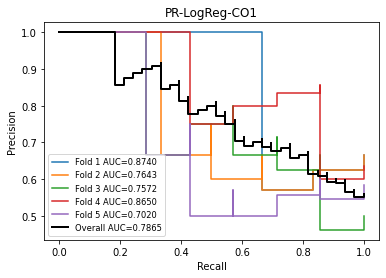

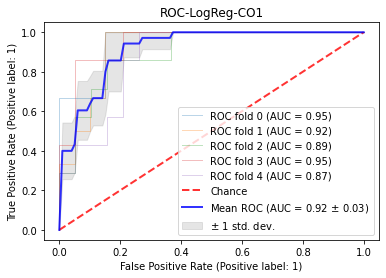

In [13]:
logisticRegClassifier_with_cross_validation(False,co1['X'],co1['Y'],1e-05, 'none','newton-cg','CO1')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used wh

{'C': 1e-05, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.609 SD: (0.127)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.13935056 0.01276069 0.60942361 0.84615385 0.73095238 0.7
 0.70432234 0.79815789]
SD [0.00621553 0.00102903 0.12676093 0.05439283 0.16172083 0.08464947
 0.08067873 0.05088891]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used wh

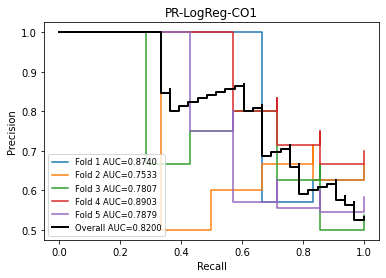

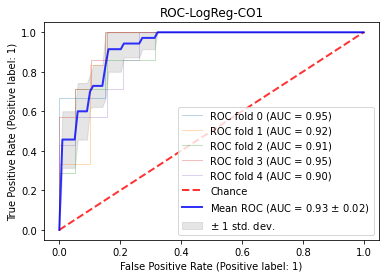

In [ ]:
logisticRegClassifier_with_cross_validation(False,co1['X'],co1['Y'],1e-05, 'none','newton-cg','CO1',best_co1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.398 SD: (0.189)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.34341893 0.01397271 0.39795632 0.68461538 0.59238288 0.73636364
 0.64042512 0.69359848]
SD [0.02413568 0.00170045 0.18928608 0.08213137 0.09234829 0.22825243
 0.13241983 0.09463804]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

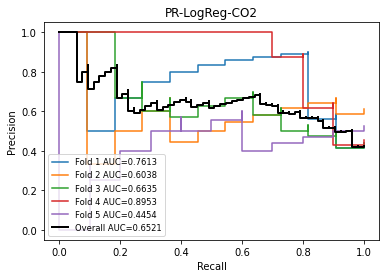

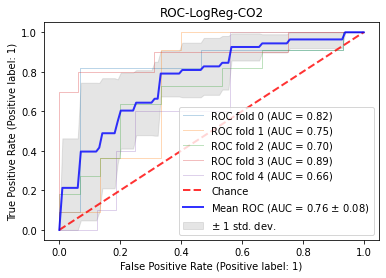

In [12]:
logisticRegClassifier_with_cross_validation(False,co2['X'],co2['Y'],0.1, 'l1','liblinear','CO2')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.442 SD: (0.196)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.07018394 0.01208935 0.44194741 0.70769231 0.63944637 0.73636364
 0.66627765 0.71318182]
SD [0.00646984 0.00052213 0.19605019 0.09294651 0.13982364 0.19717006
 0.11821021 0.09529016]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

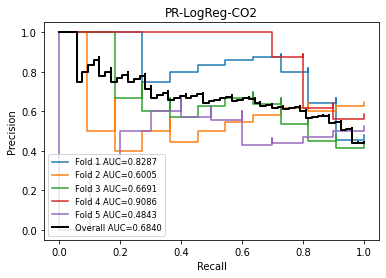

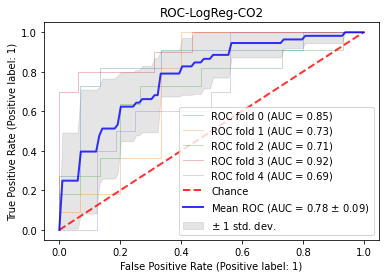

In [ ]:
logisticRegClassifier_with_cross_validation(False,co2['X'],co2['Y'],0.1, 'l1','liblinear','CO2',best_co2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used wh

{'C': 1e-05, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.531 SD: (0.090)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [1.16794472 0.04134741 0.53051158 0.83823529 0.72982684 0.54191176
 0.61949424 0.73777338]
SD [0.00898801 0.00151017 0.08991708 0.03084732 0.08300005 0.08039963
 0.0724187  0.04391547]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used wh

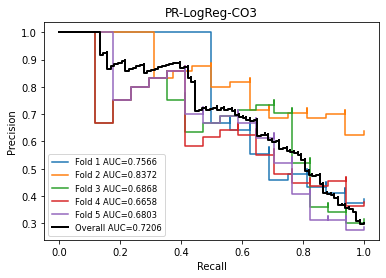

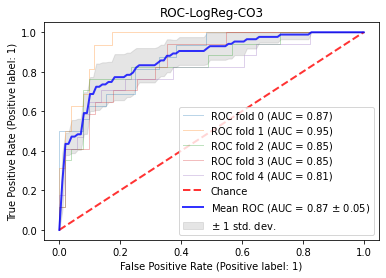

In [ ]:
logisticRegClassifier_with_cross_validation(False,co3['X'],co3['Y'],1e-05, 'none','newton-cg','CO3',best_co3)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_m

{'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.534 SD: (0.105)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.69536018 0.0377984  0.53441957 0.89411765 0.80285714 0.43090909
 0.55428571 0.70332508]
SD [0.01849518 0.00240312 0.10518375 0.02530096 0.18831151 0.04049283
 0.0713149  0.02757806]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_m

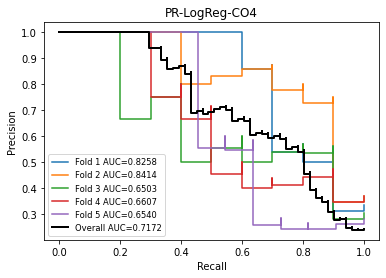

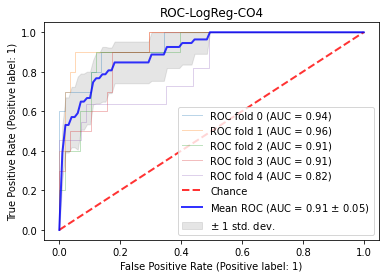

In [ ]:
logisticRegClassifier_with_cross_validation(False,co4['X'],co4['Y'],1, 'l2','lbfgs','CO4',best_co4)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

{'C': 0.01, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.863 SD: (0.024)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.30976171 0.02058783 0.86323677 0.93235294 0.92596698 0.91793103
 0.92104498 0.93069291]
SD [0.01319718 0.00036893 0.02393472 0.01176471 0.03556852 0.02709915
 0.01315462 0.01078291]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

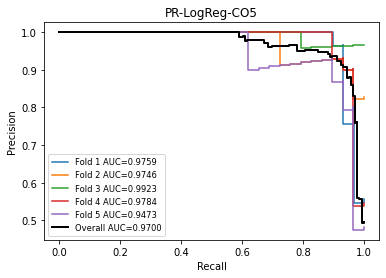

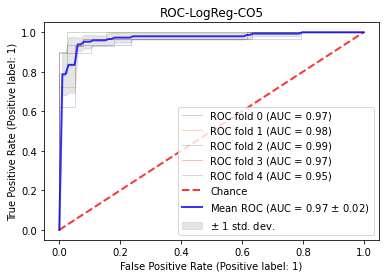

In [ ]:
logisticRegClassifier_with_cross_validation(False,co5['X'],co5['Y'],0.01, 'l1','liblinear','CO5',best_co5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

{'C': 1e-05, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.326 SD: (0.095)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.29354057 0.03247161 0.32639455 0.66764706 0.73550661 0.68
 0.70640051 0.665     ]
SD [0.0069748  0.00322966 0.09473414 0.04613055 0.04261303 0.04301163
 0.04051111 0.04776377]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

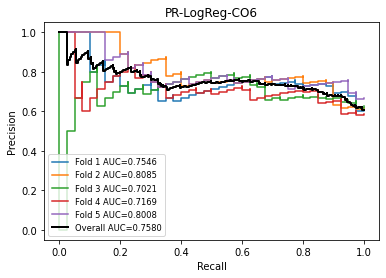

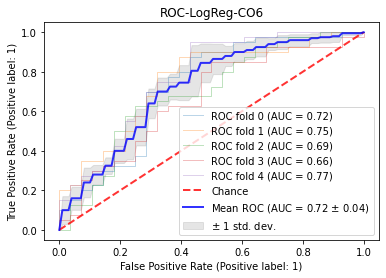

In [ ]:
logisticRegClassifier_with_cross_validation(False,co6['X'],co6['Y'],1e-05, 'l2','lbfgs','CO6',best_co6)

In [ ]:
def test_log_reg_with_crossval_with_std_data():
  print("Log-reg-CO1 started")
  logisticRegClassifier_with_cross_validation(True,co1['X'],co1['Y'],1e-05, 'none','newton-cg',230)
  print("Log-reg-CO2 started")
  logisticRegClassifier_with_cross_validation(True,co2['X'],co2['Y'],0.1, 'l1','liblinear',2930)
  print("Log-reg-CO3 started")
  logisticRegClassifier_with_cross_validation(True,co3['X'],co3['Y'],1e-05, 'none','newton-cg',3318)
  print("Log-reg-CO4 started")
  logisticRegClassifier_with_cross_validation(True,co4['X'],co4['Y'],1, 'l2','lbfgs')
  print("Log-reg-CO5 started")
  logisticRegClassifier_with_cross_validation(True,co5['X'],co5['Y'],0.01, 'l1','liblinear')
  print("Log-reg-CO6 started")
  logisticRegClassifier_with_cross_validation(True,co6['X'],co6['Y'],1e-05, 'l2','lbfgs')

In [ ]:
#test_log_reg_with_crossval_with_std_data()

In [ ]:
def logisticRegClassifier_with_FeatureTuning(X,Y,C,penalty,solver):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X.astype(np.float32))
  pipeline = Pipeline(
    [
     ('selector',SelectKBest(f_classif)),
     ('model',LogisticRegression(C=C,penalty=penalty,solver=solver,class_weight='balanced'))
    ]
  )

  #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

  search = GridSearchCV(
      estimator = pipeline,
      param_grid = {'selector__k':[int(x) for x in np.linspace(start = 5 , stop = X.shape[1], num = 100)]},
      scoring=mccScorer,
      cv=3
  )

  # execute search
  result = search.fit(X_train_scaled, Y.astype('int'))
  # summarize result
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)
  print('Mean test score:%s'% result.cv_results_['mean_test_score'])

In [ ]:
# Feature count tuning for logistic regression
def find_best_feature_count_for_logistic_regression():
  print("Log-reg-feature-tuning-CO1 started#########################################################################################################")
  logisticRegClassifier_with_FeatureTuning(co1['X'],co1['Y'],1e-05, 'none','newton-cg')
  print("Log-reg-feature-tuning-CO2 started######################################################################################################")
  logisticRegClassifier_with_FeatureTuning(co2['X'],co2['Y'],0.1, 'l1','liblinear')
  print("Log-reg-feature-tuning-CO3 started#######################################################################################################")
  logisticRegClassifier_with_FeatureTuning(co3['X'],co3['Y'],1e-05, 'none','newton-cg')
  print("Log-reg-feature-tuning-CO4 started#########################################################################################################")
  logisticRegClassifier_with_FeatureTuning(co4['X'],co4['Y'],1, 'l2','lbfgs')
  print("Log-reg-feature-tuning-CO5 started##########################################################################################################")
  logisticRegClassifier_with_FeatureTuning(co5['X'],co5['Y'],0.01, 'l1','liblinear')
  print("Log-reg-feature-tuning-CO6 started###########################################################################################################")
  logisticRegClassifier_with_FeatureTuning(co6['X'],co6['Y'],1e-05, 'l2','lbfgs')

In [ ]:
def logisticRegClassifier_with_RFE_FeatureTuning(X,Y,C,penalty,solver,numberOfFeaturesToBeSelected=1):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X.astype(np.float32))

  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected=totalNumberOfFeatures//10;

  model= LogisticRegression(C=C,penalty=penalty,solver=solver,class_weight='balanced')

  pipeline = Pipeline(
    [
     ('selector_rfe',SelectKBest(f_classif,numberOfFeaturesToBeSelected)),
     ('selector',RFE(estimator=model)),
     ('model',model)
    ]
  )

  #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

  search = GridSearchCV(
      estimator = pipeline,
      param_grid = {'selector__n_features_to_select':[int(x) for x in np.linspace(start = 5 , stop = numberOfFeaturesToBeSelected, num = 10)]},
      scoring=mccScorer,
      cv=2,
      verbose=2
  )

  # execute search
  result = search.fit(X_train_scaled, Y.astype('int'))
  # summarize result
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)
  print('Mean test score:%s'% result.cv_results_['mean_test_score'])


In [ ]:
# RFE Feature count tuning for logistic regression
def find_best_RFE_feature_count_for_logistic_regression():
  print("Log-reg-feature-tuning-CO1 started#########################################################################################################")
  logisticRegClassifier_with_RFE_FeatureTuning(co1['X'],co1['Y'],1e-05, 'none','newton-cg')
  print("Log-reg-feature-tuning-CO2 started######################################################################################################")
  logisticRegClassifier_with_RFE_FeatureTuning(co2['X'],co2['Y'],0.1, 'l1','liblinear')
  print("Log-reg-feature-tuning-CO3 started#######################################################################################################")
  logisticRegClassifier_with_RFE_FeatureTuning(co3['X'],co3['Y'],1e-05, 'none','newton-cg')
  print("Log-reg-feature-tuning-CO4 started#########################################################################################################")
  logisticRegClassifier_with_RFE_FeatureTuning(co4['X'],co4['Y'],1, 'l2','lbfgs')
  print("Log-reg-feature-tuning-CO5 started##########################################################################################################")
  logisticRegClassifier_with_RFE_FeatureTuning(co5['X'],co5['Y'],0.01, 'l1','liblinear')
  print("Log-reg-feature-tuning-CO6 started###########################################################################################################")
  logisticRegClassifier_with_RFE_FeatureTuning(co6['X'],co6['Y'],1e-05, 'l2','lbfgs')

In [ ]:
logisticRegClassifier_with_RFE_FeatureTuning(co6['X'],co6['Y'],1e-05, 'l2','lbfgs')

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] selector__n_features_to_select=5 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. selector__n_features_to_select=5, total= 2.6min
[CV] selector__n_features_to_select=5 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] ................. selector__n_features_to_select=5, total= 2.5min
[CV] selector__n_features_to_select=611 ..............................
[CV] ............... selector__n_features_to_select=611, total= 2.5min
[CV] selector__n_features_to_select=611 ..............................
[CV] ............... selector__n_features_to_select=611, total= 2.4min
[CV] selector__n_features_to_select=1218 .............................
[CV] .............. selector__n_features_to_select=1218, total= 2.4min
[CV] selector__n_features_to_select=1218 .............................
[CV] .............. selector__n_features_to_select=1218, total= 2.2min
[CV] selector__n_features_to_select=1825 .............................
[CV] .............. selector__n_features_to_select=1825, total= 2.2min
[CV] selector__n_features_to_select=1825 .............................
[CV] .............. selector__n_features_to_select=1825, total= 2.0min
[CV] selector__n_features_to_select=2432 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 31.1min finished


Best Score: 0.02976721644522913
Best Hyperparameters: {'selector__n_features_to_select': 5}
Mean test score:[ 0.02976722 -0.0593072  -0.03716817 -0.04370463 -0.02922864 -0.03860694
 -0.03384552 -0.04577747 -0.07534236 -0.06297166]
